## Importing necessary libraries

In [61]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from keras.models import Sequential
from keras.preprocessing import image
from mlxtend.plotting import plot_confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.layers import Dense, Conv2D, Dropout, Flatten, Activation
from keras.layers import SeparableConv2D, MaxPool2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

## Mounting drive

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preparing the data

In [63]:
input_dir="/content/drive/MyDrive/Colab Notebooks/images"

train_dir=os.path.join(input_dir,"train")
test_dir=os.path.join(input_dir,"test")
val_dir=os.path.join(input_dir,"val")

train_normal=os.path.join(train_dir,"NORMAL")
train_pneumonia=os.path.join(train_dir,"PNEUMONIA")

test_normal=os.path.join(test_dir,"NORMAL")
test_pneumonia=os.path.join(test_dir,"PNEUMONIA")

val_normal=os.path.join(val_dir,"NORMAL")
val_pneumonia=os.path.join(val_dir,"PNEUMONIA")

no_train_normal=len(os.listdir(train_normal))
no_train_pneumonia=len(os.listdir(train_pneumonia))

no_test_normal=len(os.listdir(test_normal))
no_test_pneumonia=len(os.listdir(test_pneumonia))

no_val_normal=len(os.listdir(val_normal))
no_val_pneumonia=len(os.listdir(val_pneumonia))

print('Total train normal images :', no_train_normal)
print('Total train pneumonia images :', no_train_pneumonia)

print('Total test normal images :', no_test_normal)
print('Total test pneumonia images :', no_test_pneumonia)

print('Total val normal images :', no_val_normal)
print('Total val pneumonia images :', no_val_pneumonia)

Total train normal images : 1341
Total train pneumonia images : 3875
Total test normal images : 234
Total test pneumonia images : 390
Total val normal images : 8
Total val pneumonia images : 8


## Plotting

In [64]:
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

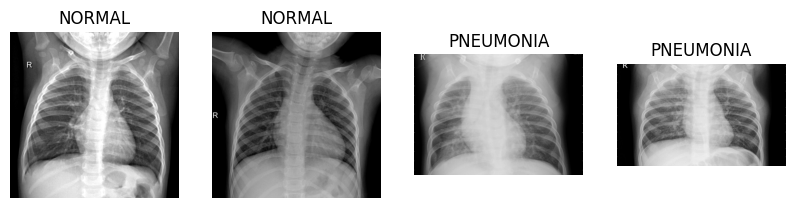

In [65]:
normal_images = os.listdir(train_normal)
pneumonia_images = os.listdir(train_pneumonia)

# Randomly select 2 'NORMAL' and 2 'PNEUMONIA' images
selected_normal_images = random.sample(normal_images, 2)
selected_pneumonia_images = random.sample(pneumonia_images, 2)

# Plot the selected images
plt.figure(figsize=(10, 5))

for i, image_name in enumerate(selected_normal_images + selected_pneumonia_images):
    image_path = os.path.join(train_normal if i < 2 else train_pneumonia, image_name)
    plt.subplot(2, 4, i + 1)
    img = mpimg.imread(image_path)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('NORMAL' if i < 2 else 'PNEUMONIA')

plt.show()


#### For training dataset

In [66]:
img_size = 150
batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./255, # transform pixeles from range 0-255 to range 0-1
                                   zoom_range = 0.3, # randomly zoom image
                                   vertical_flip = True)

training_set = train_datagen.flow_from_directory(directory = train_dir,
                                                 batch_size = batch_size,
                                                 target_size = (img_size, img_size),
                                                 shuffle = True,
                                                 class_mode = 'binary')

Found 5216 images belonging to 2 classes.


#### For testing dataset

In [67]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory(directory = test_dir,
                                            batch_size = batch_size,
                                            target_size = (img_size, img_size),
                                            shuffle = True,
                                            class_mode = 'binary')

Found 624 images belonging to 2 classes.


#### For validatiion dataset

In [68]:
val_datagen = ImageDataGenerator(rescale = 1./255)

val_set = val_datagen.flow_from_directory(directory = val_dir,
                                            batch_size = batch_size,
                                            target_size = (img_size, img_size),
                                            shuffle = True,
                                            class_mode = 'binary')

Found 16 images belonging to 2 classes.


## Building the CNN Model

In [69]:
model = Sequential()

# 1st conv
model.add(Conv2D(filters = 16, kernel_size = (3, 3), input_shape = (img_size, img_size, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))

# 2nd conv
model.add(SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))

# 3rd conv
model.add(SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# 4th conv
model.add(SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))

# 5th conv
model.add(SeparableConv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))

# fully connected layer
model.add(Flatten())
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate = 0.7))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.3))

# output layer
model.add(Dense(units = 1, activation = 'sigmoid'))

#model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 conv2d_32 (Conv2D)          (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 75, 75, 16)        0         
 ng2D)                                                           
                                                                 
 separable_conv2d (Separabl  (None, 75, 75, 32)        688       
 eConv2D)                                                        
                                                                 
 separable_conv2d_1 (Separa  (None, 75, 75, 32)        1344      
 bleConv2D)                                                      
                                                      

## Training  the Model

In [71]:
cnn = model.fit(training_set,
                epochs = 10,
                steps_per_epoch = training_set.samples // batch_size,
                validation_data = test_set,
                validation_steps = test_set.samples // batch_size)

Epoch 1/10
163/163 [==============================] - 245s 2s/step - loss: 0.3083 - accuracy: 0.8666 - val_loss: 0.8002 - val_accuracy: 0.6234
Epoch 2/10
163/163 [==============================] - 105s 643ms/step - loss: 0.2900 - accuracy: 0.8773 - val_loss: 1.3603 - val_accuracy: 0.6217
Epoch 3/10
163/163 [==============================] - 101s 621ms/step - loss: 0.2704 - accuracy: 0.8907 - val_loss: 0.5155 - val_accuracy: 0.8487
Epoch 4/10
163/163 [==============================] - 102s 625ms/step - loss: 0.2362 - accuracy: 0.9082 - val_loss: 0.9547 - val_accuracy: 0.4062
Epoch 5/10
163/163 [==============================] - 105s 647ms/step - loss: 0.2114 - accuracy: 0.9135 - val_loss: 5.6756 - val_accuracy: 0.6283
Epoch 6/10
163/163 [==============================] - 100s 617ms/step - loss: 0.2116 - accuracy: 0.9185 - val_loss: 0.8816 - val_accuracy: 0.6694
Epoch 7/10
163/163 [==============================] - 105s 641ms/step - loss: 0.1986 - accuracy: 0.9264 - val_loss: 1.2965 - va

## Evaluate the Model

In [74]:
test_accu = model.evaluate(test_set)
print('The testing accuracy is :',test_accu[1]*100, '%')

20/20 [==============================] - 8s 378ms/step - loss: 0.9743 - accuracy: 0.7388
The testing accuracy is : 73.87820482254028 %


## Confusion matrix

In [78]:
import cv2

test_data = []
test_labels = []

for title in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_dir + '/test' + title)):
            img = plt.imread(input_dir + '/test' + title + img)
            img = cv2.resize(img, (img_size, img_size))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if title == '/NORMAL/':
                label = 0
            elif title == '/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)
# get predictions
preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
# get the confusion matrix
mat = confusion_matrix(test_labels, np.round(preds))

20/20 [==============================] - 1s 13ms/step


Text(0.5, 1.0, 'Confusion Matrix')

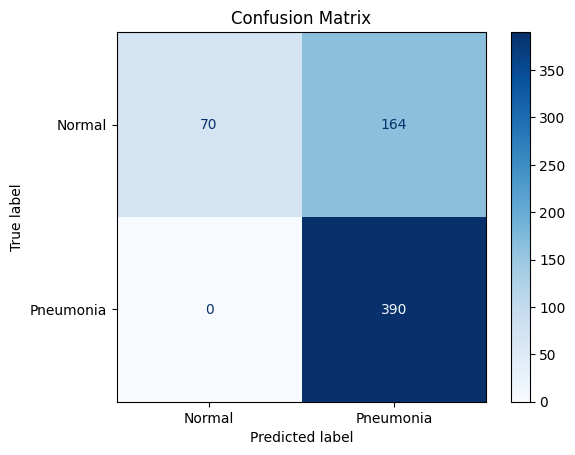

In [79]:
from sklearn.metrics import ConfusionMatrixDisplay
cmd = ConfusionMatrixDisplay(mat, display_labels=['Normal', 'Pneumonia'])
cmd.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')

## Calculate precision and recall

In [80]:
tn, fp, fn, tp = mat.ravel()
print('Test Metrics:')
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

Test Metrics:
Accuracy: 73.71794871794873%
Precision: 70.3971119133574%
Recall: 100.0%
F1-score: 82.62711864406779
